[419.0]
Point(coordinates=array([ 5.97049962e+01, -7.59603381e+02, -4.46998681e+08]))


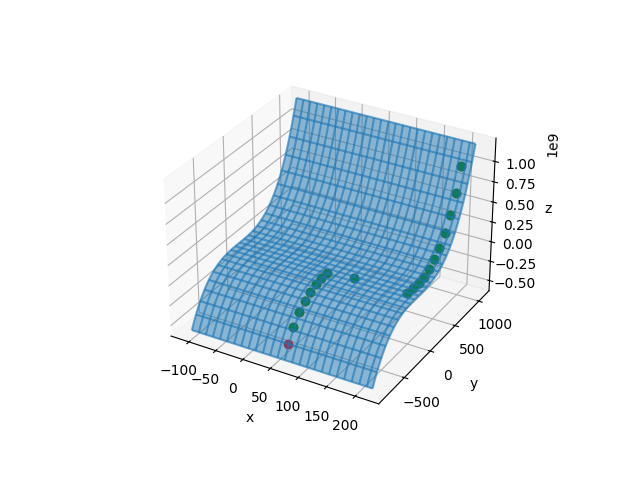

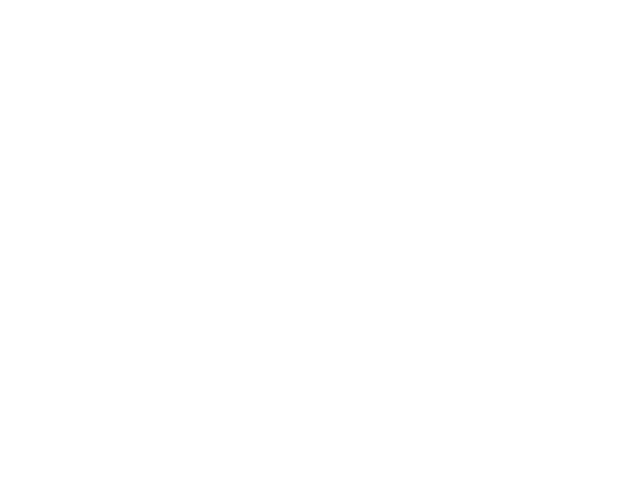

In [3]:
%matplotlib widget
from src.metric import CallCount
from src.common.oracul import LambdaOracul, PoweredSumOracul, GradientLambdaOracul

from src.lab1.stop_condition import CountCondition, PrecisionCondition
import numpy as np
from src.common import Oracul, Point
from src.lab1.method_processor import MethodProcessor
from src.lab1.methods import RandomMethod, GoldenRatioMethod, GradientDescent, BaseGradientDescent

import matplotlib.pyplot as plt

fig = plt.figure()

method = RandomMethod()
golden_ratio = GoldenRatioMethod()
gradient_descent = GradientDescent()
oracul = LambdaOracul(lambda x: (x - 10) ** 2)
test_oracul = PoweredSumOracul([[2, 2], [0, 2]])
gradient_oracul= GradientLambdaOracul(lambda x, y: (x-10)**2+(y-5)**3, lambda x, y: np.array([2*(x-10), 3*(y-5)**2],dtype=np.float64))
point, metrics, anim = MethodProcessor.process(gradient_descent, gradient_oracul, CountCondition(20), metrics=[CallCount()], method_params = {"x":np.array([200, 1000]), 'learning_rate':100}, visualize=True,
                                               low_bracket=[-100, -100], high_bracket=[200, 200])
print(metrics)
print(point)
plt.show()